# Forecasting Natural Gas International Prices using advanced Time-Series Techniques
### Problem Statement Holder <br> Gas Authority of India Ltd (GAIL) <br> PSID: SK793

<br>
<b>Author:</b> Neeraj Auchar (Team Leader)
<br>
<b>Date created:</b> Jan 15, 2022
<br>
<b>Last modified:</b> March 21, 2022
<br>
<b>Description:</b>
Forecast NATURAL GAS PRICE in international market for coming years. The system to be developed should take data input in MS Excel (CSV) format and provide the output with time-stamp. In this note book we have made an attempt to forecasting natural gas prices for next 2.5 years through various deep learning techniques 

#### Dataset Description 
Henry Hub Natural Gas Spot Price (Dollars per Million Btu)<br>
Date:	1/26/2022 <br>
Available from Web Page:	http://www.eia.gov/dnav/ng/hist/rngwhhdd.htm

### <strong>Methodology</strong>
<img src="images/Workflow.png">

In [19]:
import os
import datetime
import forcast
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import pandas as pd, numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, Reshape, Lambda

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#### Loading data Cleaning and Inspection of the Dataset 
Smoothing using Rolling mean for Multi Step output because our intrest lies in the trend more than price for long sequence 

In [10]:
csv_path= "data/dataset.csv"
df = pd.read_csv(csv_path,parse_dates=["Date"],infer_datetime_format=True)
df = df.rename(columns={'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'value'})
df['value'] = df['value'].rolling(10,min_periods=1).mean()

In [11]:
df = df[df['value'].notna()]
date_time = df.pop('Date')

#### Pop Date from the dataset 

In [12]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

#### Cyclical features encoding, it’s about time!!
<ul>
<li>Technique to transform features such as time, weeks, months preserve their cyclical significance.</li>
<li>Perform a sine and cosine transformation of the feature for encoding feature with cyclic nature.</li>
</ul>

In [13]:
month = 30*86400.0
year = 12*month

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / month))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [15]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

#### Normalization of Data 

In [16]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

#### Data Slicing and windowing 
<p>We have defined a custom utility module called forcast.py that contains methods to create the traning set using sliding window protocol. <br />In out case the input data will be of past 6 months and the output will be forvasted values of next month (assuming month has 30 days).</p>

Total window size: 210
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
Label indices: [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209]
Label column name(s): ['value']

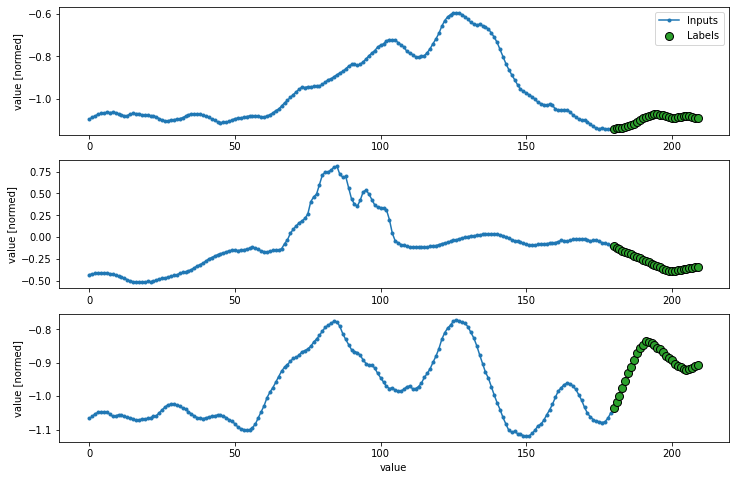

In [20]:
OUT_STEPS = 30
ipw = 30*6
multi_window = forcast.WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                                       input_width=ipw, label_width=OUT_STEPS, shift=OUT_STEPS,
                                       label_columns=['value'])

multi_window.plot('value')
multi_window

In [21]:
num_features = train_df.shape[1]
num_features

5

In [22]:
feedback_model = forcast.FeedBack(units=ipw, out_steps=OUT_STEPS,num_features=num_features)

#### Common function to compile, add callbacks and train model
<ul>
<li>Loss function: MSE (mean Squred Error)</li>
<li>Callbacks: Early Stopping, Loss Moniter</li>
<li>Optimizer: Adam</li>
<li>Evulation metrics: Mean Absolute Error</li>
<li>Number of Epoch: 100&nbsp;</li>
</ul>

In [27]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=10, MAX_EPOCHS = 100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [28]:
multi_val_performance, multi_performance = {}, {}

#### Deep Learning Architecture
<ul>
<li>Problem can be posed as a regression problem since the output is continuous</li>
<li>Given Natural Gas prices since 1997 till 2021 forecast the trend of the natural gas prices for next 5 years</li>
<li>We are dealing with regression of sequences, LSTM (Long Short Term Memory) Architecture from RNN (Recurrent Neural Networks) is considered to be the most successful and also the most popular approach to deal with sequential or time dependent data.</li>
<li>One of the appeals of RNNs is the idea that they are able to connect previous information to the present input. LSTM are a special kind of RNN, capable of learning long-term dependencies in data. LSTM offers a special memory unit to retain past information and do future computation simultaneously</li>
<li>LSTM&rsquo;s have the form of a chain of repeating modules of neural network.</li>
<li>This architecture can over 3 problems:
<ul>
<li>Temporal dependency problem</li>
<li>Sequential Data</li>
<li>Scalable</li>
</ul>
</li>
</ul>

#### Autoregressive LSTM Architecture
<ul>
<li>In traditional LSTM architectures the entire output sequence is predicted in one shot. In autoregressive model the models decompose the output sequence into individual time steps therefore the prediction at nth step is dependent on (n-1)th prediction and context/hidden vector from the past LSTM unit</li>
<li>The input to the architecture will be same as that of the multistep LSTM (initial 30*6 values) while generating output sequence the first output will be fed to the next LSTM unit along with the hidden vector and this will be repeated till we reach the end of the output sequence</li>
<li>This approach overcomes scalability challenges present in past architectures i.e they fail to forecast long sequences as in our case 2021 to 2026 where traditional approach would become impractically slow to train.</li>
</ul>



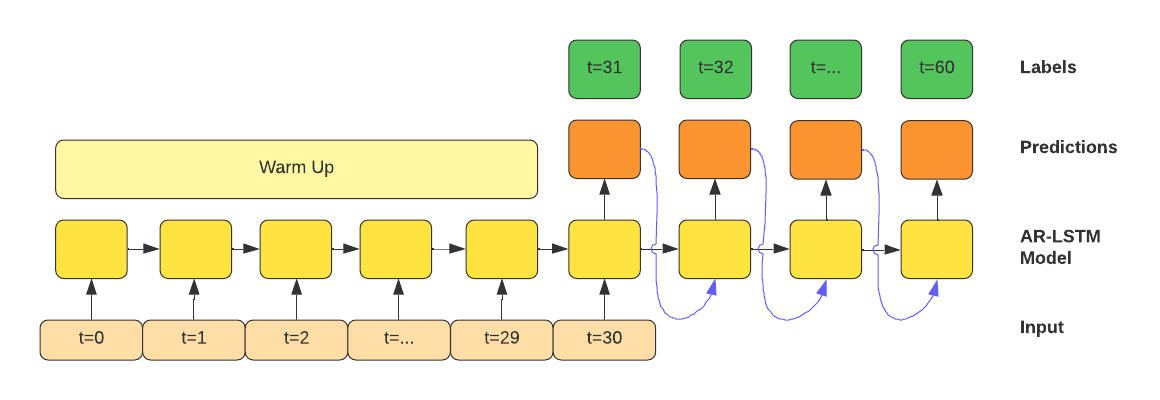

In [ ]:
feedback_model = forcast.FeedBack(units=ipw, out_steps=OUT_STEPS,num_features=num_features)

In [30]:
history_feedback_model = compile_and_fit(feedback_model, multi_window,MAX_EPOCHS=200)

Epoch 1/200
132/132 [==============================] - 69s 471ms/step - loss: 0.2221 - mean_absolute_error: 0.3224 - val_loss: 0.0518 - val_mean_absolute_error: 0.1667
Epoch 2/200
132/132 [==============================] - 61s 464ms/step - loss: 0.1478 - mean_absolute_error: 0.2610 - val_loss: 0.0334 - val_mean_absolute_error: 0.1318
Epoch 3/200
132/132 [==============================] - 61s 463ms/step - loss: 0.1354 - mean_absolute_error: 0.2516 - val_loss: 0.0281 - val_mean_absolute_error: 0.1215
Epoch 4/200
132/132 [==============================] - 61s 466ms/step - loss: 0.1118 - mean_absolute_error: 0.2288 - val_loss: 0.0488 - val_mean_absolute_error: 0.1857
Epoch 5/200
132/132 [==============================] - 61s 465ms/step - loss: 0.0872 - mean_absolute_error: 0.2016 - val_loss: 0.0269 - val_mean_absolute_error: 0.1160
Epoch 6/200
132/132 [==============================] - 61s 464ms/step - loss: 0.0756 - mean_absolute_error: 0.1919 - val_loss: 0.0301 - val_mean_absolute_error:

In [33]:
feedback_model.save('models30/AR_LSTM',save_format='tf')

INFO:tensorflow:Assets written to: models30/AR_LSTM/assets


#### AR-LSTM predictions on unseen data

33/33 [==============================] - 3s 73ms/step - loss: 0.0366 - mean_absolute_error: 0.1401
(32, 30, 5)
(32, 30, 5)
(32, 30, 5)
(32, 30, 5)
(32, 30, 5)
(32, 30, 5)


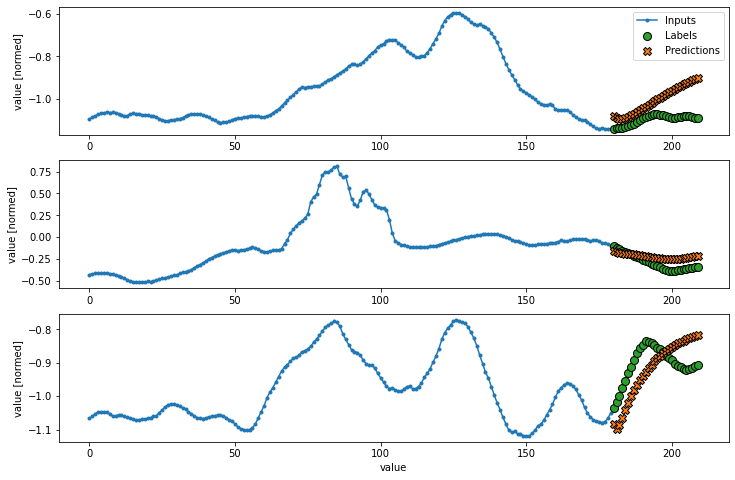

In [34]:
AR_LSTM_Hist = pd.DataFrame(history_feedback_model.history)
AR_LSTM_Hist.to_csv('history30/AR_LSTM.csv')
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot('value',feedback_model)

#### Multi Step LSTM 
<ul>
<li>In multi step LSTM input to the architecture will be a sequence of values (prices) of past 6 Month and the output will also be a sequence of predict values for next 30 days</li>
<li>The output vector from the last LSTM unit is passed to a feed forward neural network with 30 neurons</li>
<li>Each neuron will represent a value form the output sequence of next 30 days.</li>
<li>Which will be mapped against the ground truth to compute error</li>
</ul>


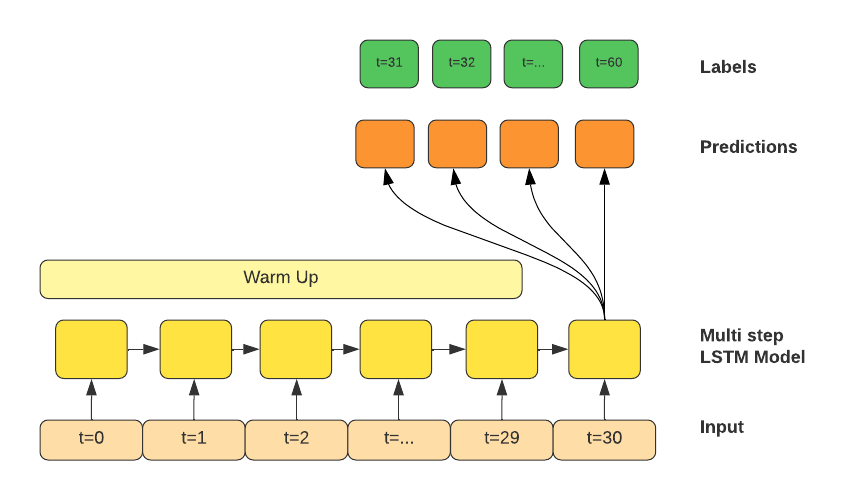

In [35]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(ipw, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history_multi_lstm_model = compile_and_fit(multi_lstm_model, multi_window)
multi_lstm_model.save('models30/LSTM.h5')

Epoch 1/100
132/132 [==============================] - 6s 25ms/step - loss: 0.3693 - mean_absolute_error: 0.4285 - val_loss: 0.0321 - val_mean_absolute_error: 0.1324
Epoch 2/100
132/132 [==============================] - 3s 19ms/step - loss: 0.1192 - mean_absolute_error: 0.2304 - val_loss: 0.0324 - val_mean_absolute_error: 0.1321
Epoch 3/100
132/132 [==============================] - 3s 19ms/step - loss: 0.1084 - mean_absolute_error: 0.2177 - val_loss: 0.0287 - val_mean_absolute_error: 0.1161
Epoch 4/100
132/132 [==============================] - 3s 19ms/step - loss: 0.0992 - mean_absolute_error: 0.2070 - val_loss: 0.0285 - val_mean_absolute_error: 0.1140
Epoch 5/100
132/132 [==============================] - 2s 18ms/step - loss: 0.0894 - mean_absolute_error: 0.1995 - val_loss: 0.0318 - val_mean_absolute_error: 0.1241
Epoch 6/100
132/132 [==============================] - 2s 17ms/step - loss: 0.0871 - mean_absolute_error: 0.1968 - val_loss: 0.0288 - val_mean_absolute_error: 0.1150
Epoc

33/33 [==============================] - 0s 10ms/step - loss: 0.0394 - mean_absolute_error: 0.1218
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)


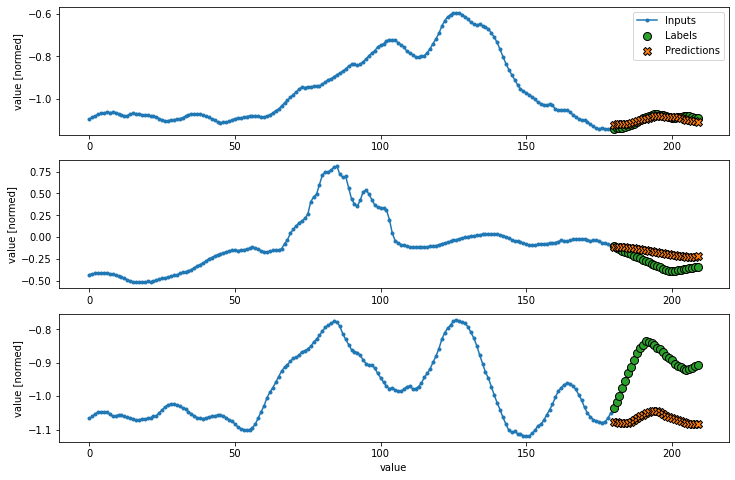

In [36]:
AR_LSTM_Hist = pd.DataFrame(history_multi_lstm_model.history)
AR_LSTM_Hist.to_csv('history30/LSTM.csv')
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot('value',multi_lstm_model)

#### Multi setp Convolution neural network
A convolution layer also takes multiple time steps as input to each prediction. We can just replace the LSTM layer in past architecture with Convolution Layer

In [37]:
CONV_WIDTH = 5
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])
history_multi_conv_model = compile_and_fit(multi_conv_model, multi_window)
multi_conv_model.save('models30/CONV.h5')

Epoch 1/100
132/132 [==============================] - 2s 9ms/step - loss: 0.2461 - mean_absolute_error: 0.3156 - val_loss: 0.0272 - val_mean_absolute_error: 0.1170
Epoch 2/100
132/132 [==============================] - 1s 7ms/step - loss: 0.1216 - mean_absolute_error: 0.2233 - val_loss: 0.0290 - val_mean_absolute_error: 0.1212
Epoch 3/100
132/132 [==============================] - 1s 8ms/step - loss: 0.1190 - mean_absolute_error: 0.2201 - val_loss: 0.0323 - val_mean_absolute_error: 0.1285
Epoch 4/100
132/132 [==============================] - 1s 8ms/step - loss: 0.1158 - mean_absolute_error: 0.2189 - val_loss: 0.0291 - val_mean_absolute_error: 0.1178
Epoch 5/100
132/132 [==============================] - 1s 7ms/step - loss: 0.1111 - mean_absolute_error: 0.2126 - val_loss: 0.0321 - val_mean_absolute_error: 0.1332
Epoch 6/100
132/132 [==============================] - 1s 6ms/step - loss: 0.1094 - mean_absolute_error: 0.2119 - val_loss: 0.0291 - val_mean_absolute_error: 0.1217
Epoch 7/10

33/33 [==============================] - 0s 5ms/step - loss: 0.0351 - mean_absolute_error: 0.1399
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)


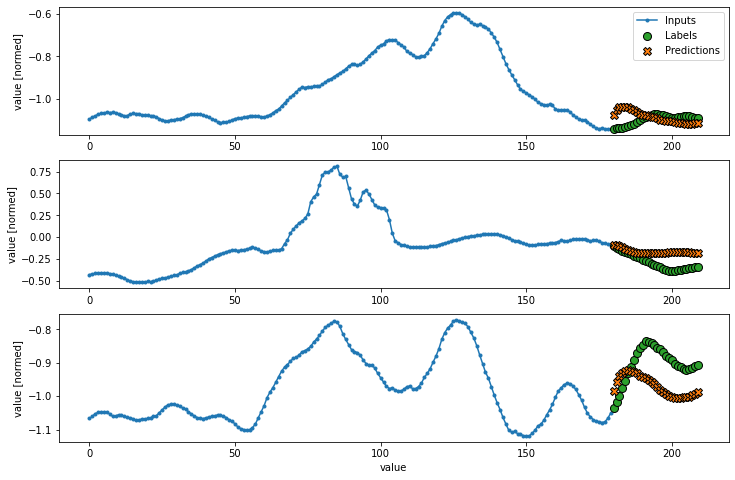

In [39]:
CONV_Hist = pd.DataFrame(history_multi_conv_model.history)
CONV_Hist.to_csv('history30/CONV.csv')
multi_val_performance['CONV'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['CONV'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot('value',multi_conv_model)

#### Time2Vec LSTM
<ul>
<li>Time is an important feature in forecasting involving events that occur synchronously and/or asynchronously</li>
<li>To effectively consume time dependent information in this approach we have provided a model-agnostic vector representation for time called Time2Vec</li>
<li>This can be easily integrated with our last LSTM architecture and improve its performances.</li>
<li>Time2vec has 3 important properties
<ul>
<li>Captures both periodic and non-periodic 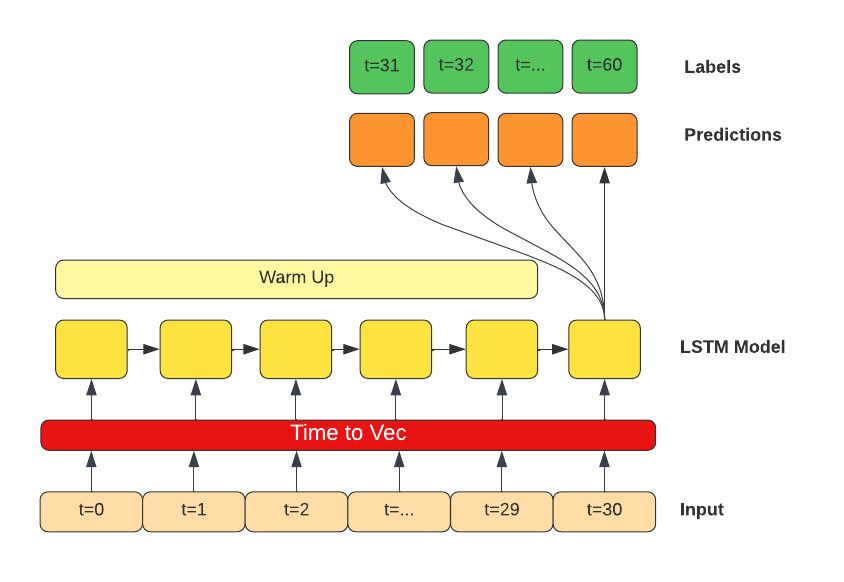patterns</li>
<li>It is invariant to time rescaling (can adapt to any scale of time measurement e.g., week, days, month)</li>
<li>being simple enough so it can be combined with many models e.g. LSTM, CNN, Transformers</li>
</ul>
</li>
</ul>

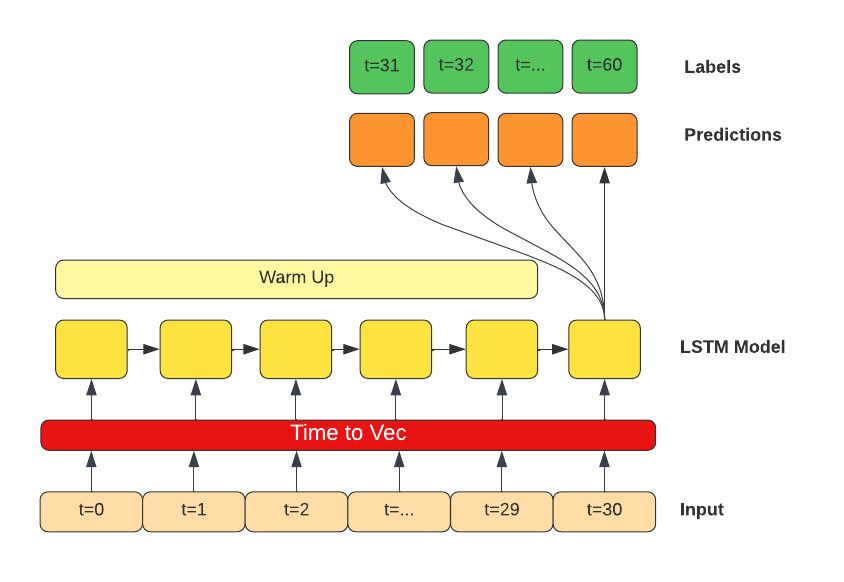

In [45]:
from tensorflow.keras.layers import *
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

from tensorflow.keras.models import *
from tensorflow.keras import backend as K
def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def T2V_NN(dim,OUT_STEPS):
    inp = Input(shape=(dim,5))
    x = T2V(64)(inp)
    x = LSTM(32, activation='relu')(x)
    x = Dense(OUT_STEPS,kernel_initializer=tf.initializers.zeros())(x)
    x = tf.keras.layers.Reshape([OUT_STEPS, 1])(x)
    m = Model(inp, x)
    return m

In [46]:
modelT2V = T2V_NN(dim=ipw,OUT_STEPS=OUT_STEPS)
history_T2V = compile_and_fit(modelT2V, multi_window)

Epoch 1/100
132/132 [==============================] - 66s 487ms/step - loss: 906275392.0000 - mean_absolute_error: 495.7842 - val_loss: 0.6107 - val_mean_absolute_error: 0.7535
Epoch 2/100
132/132 [==============================] - 64s 484ms/step - loss: 0.8997 - mean_absolute_error: 0.7198 - val_loss: 0.5636 - val_mean_absolute_error: 0.7221
Epoch 3/100
132/132 [==============================] - 64s 484ms/step - loss: 0.8814 - mean_absolute_error: 0.7066 - val_loss: 0.5196 - val_mean_absolute_error: 0.6914
Epoch 4/100
132/132 [==============================] - 64s 484ms/step - loss: 0.8643 - mean_absolute_error: 0.6938 - val_loss: 0.4777 - val_mean_absolute_error: 0.6608
Epoch 5/100
132/132 [==============================] - 64s 483ms/step - loss: 0.8485 - mean_absolute_error: 0.6815 - val_loss: 0.4386 - val_mean_absolute_error: 0.6307
Epoch 6/100
132/132 [==============================] - 64s 484ms/step - loss: 0.8338 - mean_absolute_error: 0.6696 - val_loss: 0.4019 - val_mean_absol

132/132 [==============================] - 64s 486ms/step - loss: 0.1348 - mean_absolute_error: 0.2413 - val_loss: 0.0318 - val_mean_absolute_error: 0.1284
Epoch 97/100
132/132 [==============================] - 64s 483ms/step - loss: 0.1340 - mean_absolute_error: 0.2402 - val_loss: 0.0324 - val_mean_absolute_error: 0.1263
Epoch 98/100
132/132 [==============================] - 64s 486ms/step - loss: 0.1339 - mean_absolute_error: 0.2399 - val_loss: 0.0329 - val_mean_absolute_error: 0.1257
Epoch 99/100
132/132 [==============================] - 64s 488ms/step - loss: 0.1332 - mean_absolute_error: 0.2393 - val_loss: 0.0315 - val_mean_absolute_error: 0.1249
Epoch 100/100
132/132 [==============================] - 64s 484ms/step - loss: 0.1327 - mean_absolute_error: 0.2390 - val_loss: 0.0334 - val_mean_absolute_error: 0.1259


NotImplementedError: 
Layer T2V has arguments ['self', 'output_dim']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

In [49]:
modelT2V.save_weights('models30/T2V/T2V')

33/33 [==============================] - 2s 71ms/step - loss: 0.0334 - mean_absolute_error: 0.1259
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)


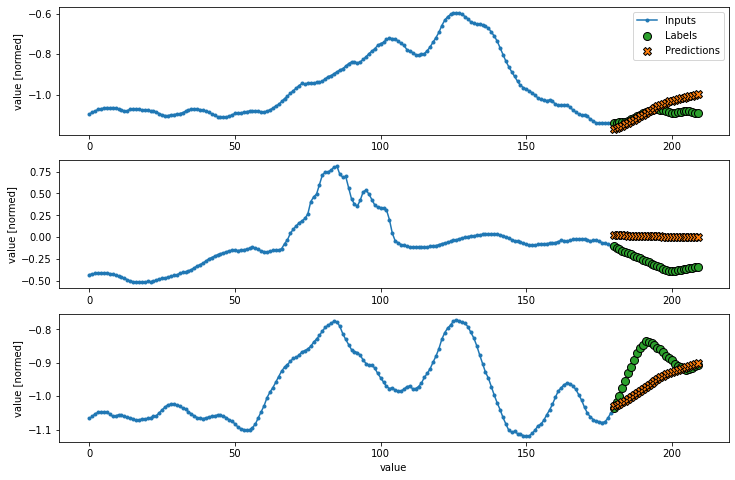

In [50]:
AR_LSTM_Hist = pd.DataFrame(history_T2V.history)
AR_LSTM_Hist.to_csv('history15/T2V.csv')
multi_val_performance['T2V'] = modelT2V.evaluate(multi_window.val)
multi_performance['T2V'] = modelT2V.evaluate(multi_window.test, verbose=0)
multi_window.plot('value',modelT2V)

#### T2V Transfomer 
<ul>
<li>Transformers are a state-of-the-art solution to Natural Language Processing (NLP) tasks. They are based on the Multihead-Self-Attention (MSA) mechanism, in which each token along the input sequence is compared to every other token in order to gather information and learn dynamic contextual information.</li>
<li>Because they do not analyze their input sequentially, Transformers largely solve the vanishing gradient problem that hinders Recurrent Neural Networks (RNNs) in long-term prediction and where output sequence is long.</li>
<li>Transfomers can also be combined will T2V techniqe that will help the architecture extract seasonal information</li>
</ul>

In [51]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate = 0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.ffn = keras.Sequential( [layers.Dense(ff_dim, activation = "gelu"), layers.Dense(feat_dim),] )
        self.layernorm1 = layers.BatchNormalization()
        self.layernorm2 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, kernel_size = 1):
        super(Time2Vec, self).__init__(trainable = True, name = 'Time2VecLayer')
        self.k = kernel_size

    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(name = 'wb', shape = (input_shape[1],), initializer = 'uniform', trainable = True)
        self.bb = self.add_weight(name = 'bb', shape = (input_shape[1],), initializer = 'uniform', trainable = True)
        # periodic
        self.wa = self.add_weight(name = 'wa', shape = (1, input_shape[1], self.k), initializer = 'uniform', trainable = True)
        self.ba = self.add_weight(name = 'ba', shape = (1, input_shape[1], self.k), initializer = 'uniform', trainable = True)
        super(Time2Vec, self).build(input_shape)

    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = K.dot(inputs, self.wa) + self.ba
        wgts = K.sin(dp) # or K.cos(.)
        ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
        ret = K.reshape(ret, (-1, inputs.shape[1] * (self.k + 1)))
        return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * (self.k + 1))
def get_model(input_shape, time2vec_dim = 3):
    inp = Input(input_shape)
    x = inp

    time_embedding = keras.layers.TimeDistributed(Time2Vec(time2vec_dim - 1))(x)
    x = Concatenate(axis = -1)([x, time_embedding])
    x = layers.LayerNormalization(epsilon = 1e-6)(x)

    for k in range(N_BLOCKS):
        x_old = x
        transformer_block = TransformerBlock(EMBED_DIM, input_shape[-1] + ( input_shape[-1] * time2vec_dim), N_HEADS, FF_DIM, DROPUT_RATE)
        x = transformer_block(x)
        x = ((1.0 - SKIP_CONNECTION_STRENGTH) * x) + (SKIP_CONNECTION_STRENGTH * x_old)

    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)
    x = Dense(OUT_STEPS,kernel_initializer=tf.initializers.zeros())(x)
    x = tf.keras.layers.Reshape([OUT_STEPS, 1])(x)
    out = x
    model = Model(inp, out)
    return model

In [52]:
input_shape = (ipw,5)

TIME_2_VEC_DIM = 8
N_BLOCKS = 3
EMBED_DIM = 16
N_HEADS = 4
DROPUT_RATE = 0.0
FF_DIM = 16
SKIP_CONNECTION_STRENGTH = 0.9
T2Vtransfomer = get_model(input_shape, TIME_2_VEC_DIM)

In [53]:
history_multi_transfomer_model = compile_and_fit(T2Vtransfomer, multi_window)

Epoch 1/100
132/132 [==============================] - 10s 42ms/step - loss: 0.2640 - mean_absolute_error: 0.3513 - val_loss: 0.0705 - val_mean_absolute_error: 0.2128
Epoch 2/100
132/132 [==============================] - 5s 35ms/step - loss: 0.1179 - mean_absolute_error: 0.2408 - val_loss: 0.0521 - val_mean_absolute_error: 0.1838
Epoch 3/100
132/132 [==============================] - 4s 32ms/step - loss: 0.0961 - mean_absolute_error: 0.2187 - val_loss: 0.0595 - val_mean_absolute_error: 0.1847
Epoch 4/100
132/132 [==============================] - 4s 33ms/step - loss: 0.0729 - mean_absolute_error: 0.1907 - val_loss: 0.0557 - val_mean_absolute_error: 0.1830
Epoch 5/100
132/132 [==============================] - 4s 33ms/step - loss: 0.0569 - mean_absolute_error: 0.1710 - val_loss: 0.0555 - val_mean_absolute_error: 0.1720
Epoch 6/100
132/132 [==============================] - 4s 32ms/step - loss: 0.0465 - mean_absolute_error: 0.1539 - val_loss: 0.0536 - val_mean_absolute_error: 0.1730
Epo

33/33 [==============================] - 1s 18ms/step - loss: 0.0571 - mean_absolute_error: 0.1716
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)


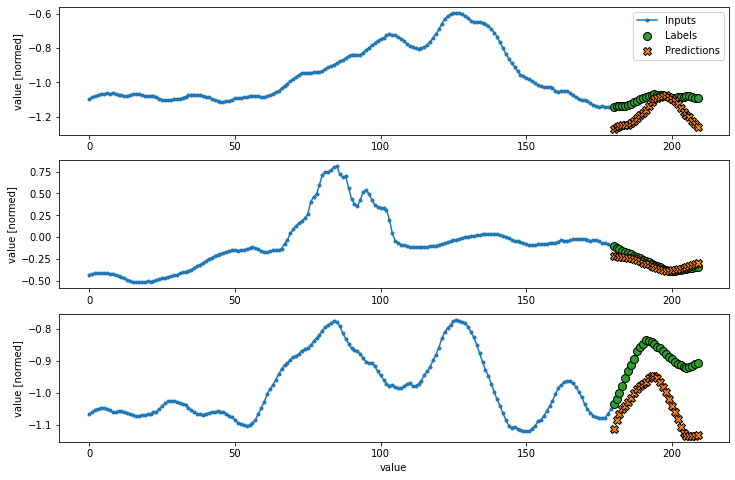

In [56]:
T2Vtransfomer.save_weights('models30/T2Vtransfomer/T2Vtransfomer')
AR_LSTM_Hist = pd.DataFrame(history_multi_transfomer_model.history)
AR_LSTM_Hist.to_csv('history15/T2Vtransfomer.csv')
multi_val_performance['T2Vtransfomer'] = T2Vtransfomer.evaluate(multi_window.val)
multi_performance['T2Vtransfomer'] = T2Vtransfomer.evaluate(multi_window.test, verbose=0)
multi_window.plot('value',T2Vtransfomer)

#### Basic Transfomer

In [57]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    x = Dense(OUT_STEPS,kernel_initializer=tf.initializers.zeros())(x)
    outputs = tf.keras.layers.Reshape([OUT_STEPS, 1])(x)
    return keras.Model(inputs, outputs)

In [58]:
basic_transfomer = build_model(
    input_shape,
    head_size=16,
    num_heads=2,
    ff_dim=2,
    num_transformer_blocks=2,
    mlp_units=[16],
    mlp_dropout=0.04,
    dropout=0.025,
)
history_basic_transfomer = compile_and_fit(basic_transfomer, multi_window)

Epoch 1/100
132/132 [==============================] - 6s 25ms/step - loss: 0.5216 - mean_absolute_error: 0.5171 - val_loss: 0.0720 - val_mean_absolute_error: 0.2321
Epoch 2/100
132/132 [==============================] - 3s 23ms/step - loss: 0.2610 - mean_absolute_error: 0.3634 - val_loss: 0.0453 - val_mean_absolute_error: 0.1740
Epoch 3/100
132/132 [==============================] - 3s 21ms/step - loss: 0.1667 - mean_absolute_error: 0.2871 - val_loss: 0.0376 - val_mean_absolute_error: 0.1457
Epoch 4/100
132/132 [==============================] - 3s 20ms/step - loss: 0.1423 - mean_absolute_error: 0.2624 - val_loss: 0.0392 - val_mean_absolute_error: 0.1501
Epoch 5/100
132/132 [==============================] - 3s 21ms/step - loss: 0.1298 - mean_absolute_error: 0.2504 - val_loss: 0.0404 - val_mean_absolute_error: 0.1498
Epoch 6/100
132/132 [==============================] - 3s 24ms/step - loss: 0.1202 - mean_absolute_error: 0.2404 - val_loss: 0.0387 - val_mean_absolute_error: 0.1444
Epoc

33/33 [==============================] - 0s 9ms/step - loss: 0.0436 - mean_absolute_error: 0.1566
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)
(32, 30, 1)


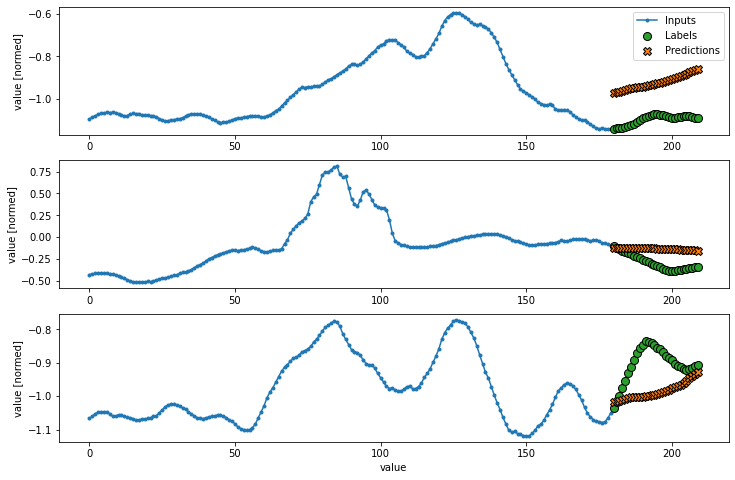

In [59]:
basic_transfomer.save_weights('models30/basic_transfomer/basic_transfomer')
AR_LSTM_Hist = pd.DataFrame(history_basic_transfomer.history)
AR_LSTM_Hist.to_csv('history15/basic_transfomer.csv')
multi_val_performance['basic_transfomer'] = basic_transfomer.evaluate(multi_window.val)
multi_performance['basic_transfomer'] = T2Vtransfomer.evaluate(multi_window.test, verbose=0)
multi_window.plot('value',basic_transfomer)

In [60]:
print(multi_performance)
import json
json_object1 = json.dumps(multi_val_performance, indent = 4)
json_object2 = json.dumps(multi_performance, indent = 4)

with open("history30/train.json", "w") as outfile:
    json.dump(multi_val_performance, outfile)
with open("history30/test.json", "w") as outfile:
    json.dump(multi_performance, outfile)

{'AR LSTM': [0.1617695391178131, 0.22776362299919128], 'LSTM': [0.22134102880954742, 0.24961961805820465], 'Conv': [0.23018509149551392, 0.26853570342063904], 'CONV': [0.2301851063966751, 0.26853570342063904], 'T2V': [0.17405666410923004, 0.2483452409505844], 'T2Vtransfomer': [0.20340710878372192, 0.30497151613235474], 'basic_transfomer': [0.20340709388256073, 0.30497145652770996]}


In [67]:
multi_val_performance

{'AR LSTM': [0.036583855748176575, 0.1400728076696396],
 'LSTM': [0.03940245136618614, 0.12183067202568054],
 'CONV': [0.03512183576822281, 0.13993202149868011],
 'T2V': [0.03338439390063286, 0.12592744827270508],
 'T2Vtransfomer': [0.05711307376623154, 0.17162573337554932],
 'basic_transfomer': [0.043639637529850006, 0.1566430777311325]}

### Results 🚨
<p><span style="color: #ff6600;">Orange bar&nbsp;<span style="color: #000000;">represents the loss on test set or the unseen data, <span style="color: #3366ff;">Blue bar <span style="color: #000000;">represents the loss on Traning set. </span></span></span></span></p>
<p><span style="color: #ff6600;"><span style="color: #000000;">As per the performance on unseen set the model from best to least can be ranked as&nbsp;</span></span></p>
<ol>
<li><span style="color: #ff6600;"><span style="color: #000000;">AR LSTM 🎉</span></span></li>
<li><span style="color: #ff6600;"><span style="color: #000000;">T2V LSTM 🎆</span></span></li>
<li><span style="color: #ff6600;"><span style="color: #000000;">T2V Transformer 👏</span></span></li>
<li><span style="color: #ff6600;"><span style="color: #000000;">Basic Transformer 🙌</span></span></li>
<li><span style="color: #ff6600;"><span style="color: #000000;">LSTM 👍</span></span></li>
<li><span style="color: #ff6600;"><span style="color: #000000;">CNN 🤦&zwj;♂️</span></span></li>
</ol>

[0.036583855748176575, 0.03940245136618614, 0.03512183576822281, 0.03338439390063286, 0.05711307376623154, 0.043639637529850006]


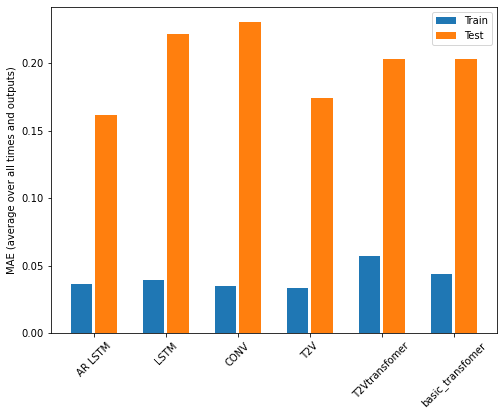

In [69]:
x = np.arange(len(multi_performance2))
width = 0.3

metric_name = 'loss'
metric_index = feedback_model.metrics_names.index('loss')
val_mae = [v[metric_index] for v in multi_val_performance2.values()]
test_mae = [v[metric_index] for v in multi_performance2.values()]
print(val_mae)
plt.bar(x - 0.17, val_mae, width, label='Train')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance2.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

[0.1400728076696396, 0.12183067202568054, 0.13993202149868011, 0.12592744827270508, 0.17162573337554932, 0.1566430777311325]


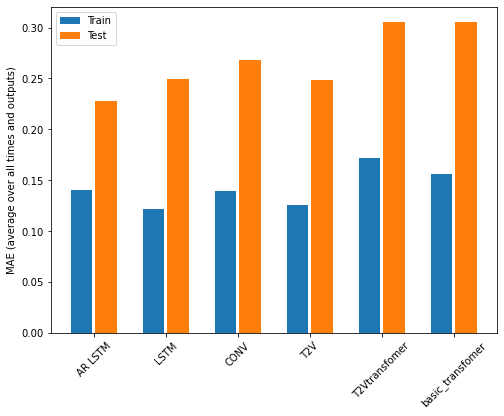

In [68]:

x = np.arange(len(multi_performance2))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = feedback_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance2.values()]
test_mae = [v[metric_index] for v in multi_performance2.values()]
print(val_mae)
plt.bar(x - 0.17, val_mae, width, label='Train')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance2.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()